---

***Filename***: main.ipynb

---

***Description***: This notebook implements and evaluates the proposed guitar string detection algorithm.

---
***Author***: Alexandros Iliadis


***Project***: GS-Detector

***Date***: February 2024

---

### Section I:

This section handles preliminary tasks such as assigning the working directory, importing necessary modules, selecting the dataset for evaluation, and configuring variables related to the guitar setup.

In [1]:
# Mount Drive
from google.colab import drive
drive.mount("/content/gdrive")

# Change Directory
import os
cwd = "/content/gdrive/My Drive/Colab/MSc/Audio Signal Processing/Project"
os.chdir(cwd)

In [2]:
# Import Modules
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xml
from scipy.optimize import curve_fit
from scipy.signal import stft,find_peaks

In [3]:
# Select Dataset
dataset_selection = 0
dataset = ["Bridge Pickup","Middle Pickup","Neck Pickup"][dataset_selection % 3]

# Set Paths
dataset_path = os.path.join(cwd,"Datasets",dataset)
audio_path = os.path.join(dataset_path,"audio")
annotation_path = os.path.join(dataset_path,"annotation")

In [4]:
# Configure Guitar Setup
tuning = dict(zip(["E4","B3","G3","D3","A2","E2"],[64,59,55,50,45,40]))
num_of_strings = len(tuning)
num_of_frets = 12 + 1
fretboard = np.array(list(tuning.values()))[:,np.newaxis] + np.arange(num_of_frets)

# Assign Note Pitches to Fundamental Frequencies
pitches = np.arange(list(tuning.values())[-1],list(tuning.values())[0] + num_of_frets)
fundamentals = dict(zip(pitches,440*2**((pitches - 69)/12)))

### Section II:

This section computes the inharmonicity coefficient for all note instances of the selected dataset. The approach includes applying the Short-Time Fourier Transform (STFT) on the note signals and performing partial tracking on every audio block between the onset and offset timestamps. Once the partial frequencies on a block have been detected, a curve-fitting process is deployed to extract the inharmonicity coefficient. After removing possible outliers, the median value across all blocks is calculated.

In [5]:
# Initialize Inharmonicity Matrix
B_computed = np.zeros((num_of_strings,num_of_frets))

# Loop Through Files
files = sorted(os.listdir(annotation_path))
for file in files:

    # Load Annotation
    annotation_file = os.path.join(annotation_path,file)
    annotation = xml.parse(annotation_file).getroot()[1][0]
    pitch = int(annotation.find('pitch').text)
    string = 7 - int(annotation.find('stringNumber').text)
    fret = int(annotation.find('fretNumber').text)
    onset = float(annotation.find('onsetSec').text)
    offset = float(annotation.find('offsetSec').text)

    # Load Audio
    audio_file = os.path.join(audio_path,file[:-4] + ".wav")
    audio,fs = sf.read(audio_file)

    # Get Spectrogram
    window_type = 'hann'
    window_length = 2048
    overlap_length = window_length/2
    fft_length = 2**18
    f_axis,t_axis,spectrogram = stft(audio,fs,window_type,window_length,overlap_length,fft_length)

    # Loop Through Blocks
    blocks = np.where((t_axis >= onset + (window_length/2)/fs) & (t_axis <= offset - (window_length/2)/fs))[0]
    B = np.zeros(len(blocks))
    for index,block in enumerate(blocks):

        # Get Spectrum
        spectrum = np.abs(spectrogram[:,block])
        spectrum = (spectrum-np.min(spectrum))/(np.max(spectrum) - np.min(spectrum))
        threshold = 0.01
        spectrum[spectrum <= threshold] = 0
        
        # Track Partials
        f0 = fundamentals[pitch]
        search_window = f0/2
        max_partials = np.minimum(15,int((fs/2)/f0))
        fk_estimated = np.zeros(max_partials)
        fk_index = np.zeros(max_partials,dtype = int)
        fk_computed = np.zeros(max_partials)
        for k in range(max_partials):
            if k == 0:
                fk_estimated[k] = (k + 1)*f0
                search_window = fk_estimated[k]/2
            else:
                fk_estimated[k] = (k + 1)*fk_computed[0]
            search_range = np.where((f_axis > fk_estimated[k] - search_window/2) & (f_axis < fk_estimated[k] + search_window/2))[0]
            peaks = find_peaks(spectrum[search_range])[0]
            if peaks.size == 0:
                k = k - 1
                break
            fk_index[k] = search_range[peaks[np.argmax(spectrum[search_range][peaks])]]
            fk_computed[k] = f_axis[fk_index[k]]
        k = k + 1
        fk_estimated = fk_estimated[:k]
        fk_index = fk_index[:k]
        fk_computed = fk_computed[:k]

        # Compute Inharmonicity Coefficient
        if(k >= 2):
            k_axis = np.arange(k) + 1
            ratio = (fk_computed/fk_computed[0])**2
            B[index] = curve_fit(lambda k,B : k**2 + B*k**4,k_axis,ratio,bounds = (0,np.inf))[0][0]
        else:
            B[index] = np.nan

    # Update Inharmonicity Matrix
    B_computed[string - 1,fret] = np.median(B[(B > 10**(-7)) & (B < 10**(-2))])
    print(f"String: {string} | Fret: {fret} {' ' * int(fret < 10)}|| Inharmonicity: {'{:.3e}'.format(B_computed[string - 1,fret])}")

String: 6 | Fret: 0  || Inharmonicity: 2.733e-04
String: 6 | Fret: 1  || Inharmonicity: 2.876e-04
String: 6 | Fret: 2  || Inharmonicity: 3.121e-04
String: 6 | Fret: 3  || Inharmonicity: 3.234e-04
String: 6 | Fret: 4  || Inharmonicity: 4.318e-04
String: 6 | Fret: 5  || Inharmonicity: 3.635e-04
String: 5 | Fret: 0  || Inharmonicity: 1.216e-04
String: 6 | Fret: 6  || Inharmonicity: 5.261e-04
String: 5 | Fret: 1  || Inharmonicity: 1.496e-04
String: 6 | Fret: 7  || Inharmonicity: 6.508e-04
String: 5 | Fret: 2  || Inharmonicity: 2.099e-04
String: 6 | Fret: 8  || Inharmonicity: 7.375e-04
String: 5 | Fret: 3  || Inharmonicity: 2.393e-04
String: 6 | Fret: 9  || Inharmonicity: 8.578e-04
String: 5 | Fret: 4  || Inharmonicity: 2.886e-04
String: 6 | Fret: 10 || Inharmonicity: 9.489e-04
String: 5 | Fret: 5  || Inharmonicity: 2.609e-04
String: 4 | Fret: 0  || Inharmonicity: 1.094e-04
String: 6 | Fret: 11 || Inharmonicity: 9.801e-04
String: 5 | Fret: 6  || Inharmonicity: 2.698e-04
String: 4 | Fret: 1 

### Section III:

This section evaluates the guitar string detection algorithm based on a selected adaptation scheme. After calculating the scheme's coefficients, the estimated inharmonicity curves are calculated. Then, the candidate string-fret pairs of the fretboard with the same pitch are extracted for every note that hasn't been utilized during the adaptation phase. Among these candidates, the one with the minimum absolute distance between its corresponding estimated inharmonicity value and the computed inharmonicity of the note instance is selected from the classification process. For unbiased results, notes that have only one candidate string-fret pair are excluded, since their correct classification is essentially predetermined. Finally, the confusion matrix and the accuracy measure of the classification are calculated and presented.

Actual -> String: 6 | Fret: 5  || Classified -> String: 6 | Fret: 5  || Classification: Correct
Actual -> String: 6 | Fret: 6  || Classified -> String: 6 | Fret: 6  || Classification: Correct
Actual -> String: 6 | Fret: 7  || Classified -> String: 6 | Fret: 7  || Classification: Correct
Actual -> String: 6 | Fret: 8  || Classified -> String: 6 | Fret: 8  || Classification: Correct
Actual -> String: 6 | Fret: 9  || Classified -> String: 6 | Fret: 9  || Classification: Correct
Actual -> String: 6 | Fret: 10 || Classified -> String: 6 | Fret: 10 || Classification: Correct
Actual -> String: 6 | Fret: 11 || Classified -> String: 6 | Fret: 11 || Classification: Correct
Actual -> String: 6 | Fret: 12 || Classified -> String: 6 | Fret: 12 || Classification: Correct
Actual -> String: 5 | Fret: 1  || Classified -> String: 5 | Fret: 1  || Classification: Correct
Actual -> String: 5 | Fret: 2  || Classified -> String: 5 | Fret: 2  || Classification: Correct
Actual -> String: 5 | Fret: 3  || Classi

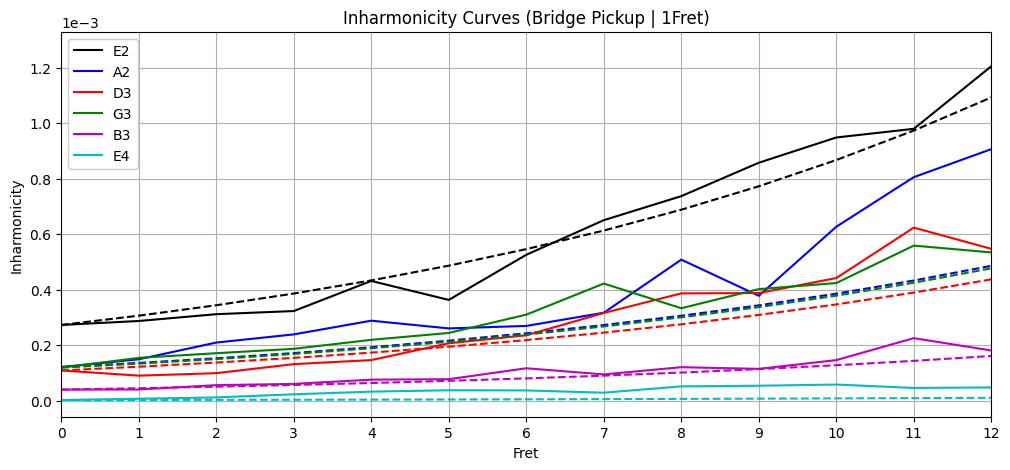

In [6]:
# Select Scheme
scheme_selection = 0
scheme = ["1Fret","2FretA","2FretB","3Fret"][scheme_selection % 4]
scheme_frets = [(0,),(0,12),(0,12),(0,3,12)][scheme_selection % 4]

# Calculate Coefficients
a = np.ones(num_of_strings)
b = np.zeros(num_of_strings) 
if scheme == "1Fret":
    pass
elif scheme == "2FretA":
    fret = scheme_frets[1]
    for s in range(num_of_strings):
        a[s] = 6*np.log2(B_computed[s,fret]/B_computed[s,0]) / fret
elif scheme == "2FretB":
    fret = scheme_frets[1]
    for s in range(num_of_strings):
        b[s] = 6*np.log2(B_computed[s,fret]/B_computed[s,0]) - a[s]*fret
elif scheme == "3Fret":
    fret1 = scheme_frets[1]
    fret2 = scheme_frets[2]
    for s in range(num_of_strings):
        a[s] = 6*np.log2(B_computed[s,fret1]/B_computed[s,fret2]) / (fret1 - fret2)
        b[s] = 6*np.log2(B_computed[s,fret1]/B_computed[s,0]) - a[s]*fret1
    
# Calculate Estimated Inharmonicity
B_estimated = np.zeros((num_of_strings,num_of_frets))
B_estimated[:,0] = B_computed[:,0]
B_estimated[:,1:] = B_computed[:,0,np.newaxis]*2**((a[:,np.newaxis]*np.arange(1,num_of_frets) + b[:,np.newaxis])/6)

# Calculate Confusion Matrix
confusion_matrix = np.zeros((num_of_strings,num_of_strings),dtype = int)
for string in reversed(range(num_of_strings)):
    for fret in range(num_of_frets):
        if fret not in scheme_frets:
            pitch = fretboard[string,fret]
            candidates = np.flip(np.vstack(np.where(fretboard == pitch)).T,axis = 0)
            if len(candidates) > 1:
                distance = np.zeros(len(candidates))
                for index in range((len(candidates))):
                    distance[index] = B_computed[string,fret] - B_estimated[candidates[index][0],candidates[index][1]]
                classification = candidates[np.argmin(np.abs(distance))]
                confusion_matrix[classification[0],string] += 1
                print(f"Actual -> String: {string + 1} | Fret: {fret} {' '*int(fret < 10)}|| Classified -> String: {classification[0] + 1} | Fret: {classification[1]} {' '*int(classification[1] < 10)}|| Classification: {'Correct'*int(classification[0] == string)}{'Incorrect'*int(classification[0] != string)}")
print(f"\nConfusion Matrix:\n{confusion_matrix}")

# Calculate Accuracy
total_classifications = np.sum(confusion_matrix)
print(f"\nTotal Classifications: {total_classifications}")
correct_classifications = np.trace(confusion_matrix)
print(f"Correct Classifications: {correct_classifications}")
incorrect_classifications = total_classifications - correct_classifications
print(f"Incorrect Classifications: {incorrect_classifications}\n")
accuracy = correct_classifications/total_classifications
print(f"Accuracy: {accuracy*100:.2f}%")

# Plot Inharmonicity Curves
fig = plt.figure(figsize = (12,5))
colors = ['c','m','g','r','b','k']
for s in reversed(range(num_of_strings)):
    plt.plot(np.arange(num_of_frets),B_computed[s,:],color = colors[s],label = list(tuning.keys())[s])
    plt.plot(np.arange(num_of_frets),B_estimated[s,:],linestyle = '--',color = colors[s])
plt.xlim(0,12)
plt.xticks(np.arange(num_of_frets))
plt.ticklabel_format(axis = 'y',style = 'scientific',scilimits = (0,0))
plt.xlabel("Fret")
plt.ylabel("Inharmonicity")
plt.title(f"Inharmonicity Curves ({dataset} | {scheme})")
plt.legend(loc = 'upper left',framealpha = 1)
plt.grid(True,zorder = 1)